In [1]:
import jax
import jax.numpy as jnp
import immrax as irx

from fit_params import fit
from functools import partial

# wrap the jax.jit function to set the backend to cpu by default for convenience
device = 'cpu'
def jit (*args, **kwargs):
    kwargs.setdefault('backend', device)
    return jax.jit(*args, **kwargs)

print(jax.devices())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]


In [2]:
# Actual System Dynamics
class KinematicBike (irx.System) :
    def __init__(self) -> None:
        self.evolution = 'continuous'
        self.xlen = 4
        self.lr = 5.5*0.6
        self.lf = 5.5*0.4
    def f(self, t:jnp.ndarray, x:jnp.ndarray, u:jnp.ndarray, w:jnp.ndarray) -> jnp.ndarray :
        px, py, psi, v = x[0], x[1], x[2], x[3]
        u1, u2 = u[0], u[1]
        beta = jnp.arctan(self.lr*jnp.tan(u2)/(self.lr+self.lf))

        a = u1*(1 - w)
        return jnp.array([
            v*jnp.cos(psi + beta),
            v*jnp.sin(psi + beta),
            (v/self.lr)*jnp.sin(beta),
            a
        ])

In [3]:
# Embedding System Dynamics
# custom inclusion function for kinematic bicycle

d_prod = irx.natif(jnp.dot)    
d_sin = irx.natif(jnp.sin)
d_cos = irx.natif(jnp.cos)
d_abs = irx.natif(lambda x: jnp.sqrt(x**2))
d_exp = irx.natif(jnp.exp)
    
    
def F (t, x, u, buffer) :
    px, py, psi, v = x[0], x[1], x[2], x[3]
    a, delta = u[0], u[1]

    
    lr = 5.5*0.6
    lf = 5.5*0.4
    
    beta = jnp.arctan(lr*jnp.tan(delta)/(lr+lf))

    mean = 0.2
    w = irx.interval(mean - buffer, mean + 4 * buffer)

    dx = d_prod(v, d_cos(psi + beta))
    dy = d_prod(v, d_sin(psi + beta))
    dpsi = d_prod(v/lr, d_sin(beta))
    dv = d_prod(a, irx.interval(1) - w)
    # must cast all constants that math with intervals to also be intervals (except division)
    # this is a known issue with the current implementation of immrax that will be difficult to fix

    
    return irx.interval([dx.lower, dy.lower, dpsi.lower, dv.lower], 
                        [dx.upper, dy.upper, dpsi.upper, dv.upper])

In [4]:
# BEGIN MPC PROBLEM
from cyipopt import minimize_ipopt

# PARAMETERS
dt = 0.1 # time step
t0 = 0. # initial time
th = 1.5 # horizon time
N = round((th - t0)/dt) + 1 # number of time steps
tt = jnp.arange(t0, th + dt, dt) # time vector
# buffer_list = jnp.array([0.319, 0.674, 1.15, 2.576]) # represents, 0.25, 0.5, 0.75, 0.99 probability bounds
# buffer_list = jnp.array([0.426, 0.954, 2.576]) # represents, 0.33, 0.66, 0.99 probability bounds
# prob_list = buffer_list

# full distribution
buffer_list = jnp.array([0.025, 0.05, 0.075, 0.1]) # hardcoded values
prob_list = jnp.array([0.25, 0.5, 0.75, 1.0]) # hardcoded values

# conservative
# buffer_list = jnp.array([0.1]) # hardcoded values
# prob_list = jnp.array([1.0]) # hardcoded values

# reckless
# buffer_list = jnp.array([0.025]) # hardcoded values
# prob_list = jnp.array([0.25]) # hardcoded values

print(len(buffer_list))

# list of obstacles in [x_lower, y_lower, x_upper, y_upper] format
# obstacles = jnp.array([[1.5, 1., 3., 3.],
#                        [1., -3, 3, -1],
#                        [5., 6, 6, 7],
#                        [5., -1, 6, 1]])
obstacles = jnp.array([[5., -10., 6., 10.]])
                    #    [0., -6., 8., -5.]])

# goal region in [x_lower, y_lower, x_upper, y_upper] format
# goal = jnp.array([3.75, -0.5, 4.75, 0.5]) # initial
goal = jnp.array([3.9, -0.5, 4.9, 0.5])

x0_t = jnp.array([2., -0.05, 0., 0., 2.1, 0.05, 0., 0.]) # initial state of embedding system

4


In [5]:
# Create embedding system
kinbike = KinematicBike()
KBGPEMB = irx.ifemb(kinbike, F)

# initialize input vector
u0_t = jnp.zeros((N, 2)).reshape(-1)
print(u0_t)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
# Function to rollout the undisturbed dynamics using Euler integration
@jit
def rollout_ol_sys_undisturbed (u:jax.Array, xinit:jax.Array, buffer:jax.float0) -> jax.Array :
    # xinit = u[:8] # initial state
    # obs = u[8:17].reshape(-1, 3) # observation points
    # u = u[17:].reshape(-1, 2) # inputs

    # print(xinit)
    # print(obs)

    def f_euler (xt, ut) :
        xtp1 = xt + dt*KBGPEMB.f(0., xt, ut, buffer)
        return (xtp1, xtp1)
    _, x = jax.lax.scan(f_euler, xinit, u.reshape(-1, 2))
    # print(x)
    return x

@jit
def distribution_rollout(u:jax.Array, xinit:jax.Array) -> jax.Array :
    x = jnp.zeros((len(buffer_list), N, 8))
    for i, buffer in enumerate(buffer_list):
        x = x.at[i, :, :].set(rollout_ol_sys_undisturbed(u, xinit, buffer))
    return x

# compares two embedding system states to see if southeast order is preserved
def SE_order(xin, yin):
    if xin.ndim == 1 and yin.ndim == 1:
        half_index = int(xin.size/2)
        # print(half_index)

        # separate x and xhat (NOT lower and upper bounds, as we need to be able to check intersection as well)
        x = xin[0:half_index]
        xhat = xin[half_index:]
        y = yin[0:half_index]
        yhat = yin[half_index:]
    elif xin.ndim == 2 and yin.ndim == 2:
        half_index = int(xin.shape[1]/2)

        # separate x and xhat (NOT lower and upper bounds, as we need to be able to check intersection as well)
        x = xin[:,0:half_index]
        xhat = xin[:,half_index:]
        y = yin[:,0:half_index]
        yhat = yin[:,half_index:]
    else:
        raise ValueError("Input dimensions do not match")

    # returns all positive values if SE order preserved (i.e. y is contained in x)
    val = jnp.array([y - x, xhat-yhat])
    se = jnp.all(val >= 0) # single boolean value, is SE order preserved (yes/no)?

    return se, val

def intersection(x, y):
    half_index = int(y.size/2)
    y_end = y[0:half_index]
    y = y.at[0:half_index].set(y[half_index:])
    y = y.at[half_index:].set(y_end)
    # print(x, y)
    se, val = SE_order(x, y)
    # print(val)
    # print(jnp.min(val, axis=0))

    # returns 0 if no intersection, otherwise returns intersection area
    return jnp.max(jnp.array([0, (-1 + 2*se)*jnp.abs(jnp.prod(jnp.min(val, axis=0)))])) 

# test intersection (should return 0.25)
x = jnp.array([1., 2., 2.5, 3.])
y = jnp.array([2., 1., 3., 2.5])
print(intersection(x, y))

# test intersection (should return 0)  
x = jnp.array([1., 2., 2.5, 3.])
y = jnp.array([3., 1., 4., 2.5])
print(intersection(x, y))

x = jnp.array([2.876, -1.326, 5.737,  0.469])
y = obstacles[0, :]
print(intersection(x, y))

x = jnp.array([2.876, -1.326, 5.737,  0.469])
y = goal
print(intersection(x, y))

0.25
0.0
7.715653
1.7800529


In [7]:
# DEFINE COST/OBJECTIVE FUNCTION (MINIMIZE)
@jit
def obj (u:jax.Array, xinit:jax.Array) -> jax.Array :
    # x = compute_traj(u)
    x = distribution_rollout(u, xinit)
    # return -1 * jnp.sum(x[:,:,0] + (x[:,:,4] - x[:,:,0])/2.) # for now, just want to move right as far as possible
    # new cost function: get to goal, while avoiding obstacles, weight reward/punishment based on reachable set probability & amount of intersection
    
    # initialize as distance to goal
    centers = x[:, :, [0, 1]] + (x[:, :, [4, 5]] - x[:, :, [0, 1]])/2.
    goal_center = goal[0:2] + (goal[2:] - goal[0:2])/2.
    val = 0.005 * jnp.sum(jnp.linalg.norm(goal_center - centers, 2, axis=2))

    # check for intersections with obstacles and goal
    for i in range(x.shape[0]):
        prob = prob_list[i]
        for j in range(x.shape[1]):
            # pull from x and flip to check intersections
            # rect = x[i, j, [4, 5, 0, 1]]
            # jk don't flip
            rect = x[i, j, [0, 1, 4, 5]]
            area = (rect[2] - rect[0])*(rect[3] - rect[1])
            # print(rect)
            # check obstacles
            for o in range(obstacles.shape[0]):
                # punish for intersection with obstacles
                val += 10 * prob * intersection(rect, obstacles[o, :])/area
                
            # check goal, reward for intersection
            val += -10 * prob * intersection(rect, goal)/area
    print("COMPILED")
    return val
    

# DEFINE EQUALITY CONSTRAINT FUNCTION (CURRENTLY UNUSED)
def constraint_function (u, x, w) :
    return irx.norm(x, 2) + irx.norm(u, 2) + irx.norm(w, 2)

# DEFINE INEQUALITY CONSTRAINT FUNCTION (POSITIVE VALUES INDICATE FULFILLMENT)
@jit
def con_ineq (u, xinit):
    # x = compute_traj(u)
    x = distribution_rollout(u, xinit)
    # print(x)
    # result = jnp.hstack([preserve_order(x), avoid_obstacles(x)])
    result = preserve_order(x)
    return result

def preserve_order(x):
    diff = x[:, :, 4:] - x[:, :, :4]
    return diff.reshape(-1)

# if avoiding obstacles is a requirement, then this function should be used
def avoid_obstacles(x):
    result = []
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            for k in range(obstacles.shape[0]):
            

                # check if the southeast order is preserved when obstacle is flipped
                # print(x[i, [0, 1, 4, 5]], obstacles[j, [2, 3, 0, 1]])
                # _, val = SE_order(jnp.array(x[i, [0, 1, 4, 5]]), jnp.array(obstacles[j, [2, 3, 0, 1]]))
                val = intersection(x[i, j, [0, 1, 4, 5]], obstacles[k, :])
                # print(val)
                # if all positive, then intersection is happening, so multiply by -1 to match inequality constraint requirements
                result.append(-1. * jnp.min(val))
    return jnp.array(result).reshape(-1)

print(obj(u0_t, x0_t))

COMPILED
0.752


In [8]:
# DEFINE MPC PROBLEM
obj_grad = jit(jax.grad(obj, argnums=0))  # Objective Gradient
obj_hess = jit(jax.jacfwd(jax.jacrev(obj, argnums=0), argnums=0))  # Objective Hessian
con_ineq_jac = jit(jax.jacfwd(con_ineq, argnums=0))  # Constraint Jacobian
con_ineq_hess = jit(jax.jacfwd(jax.jacrev(con_ineq, argnums=0), argnums=0)) # Constraint Hessian



# Constraint Hessian-Vector Product
@jit
def con_ineq_hessvp (u, v, xinit) :
    def hessvp (u) :
        _, hvp = jax.vjp(con_ineq, u, xinit)
        return hvp(v)[0] # One tangent, one output. u^T dc_v
    return jax.jacrev(hessvp)(u) 

In [9]:
# print('JIT Compiling Autodiff Functions...')
# from time import time
# time0 = time()

# obj(u0_t, x0_t, obs_t)  # run once to compile
# obj_grad(u0_t, x0_t, obs_t)
# obj_hess(u0_t, x0_t, obs_t)
# con_ineq(u0_t, x0_t, obs_t)
# con_ineq_jac(u0_t, x0_t, obs_t)
# # con_ineq_hessvp(u0_t, jnp.ones(4*N), x0_t, obs_t)
# timef = time()
# print(f'Finished JIT Compiling Autodiff Functions in {timef - time0} seconds')

In [10]:
# This block is just to run the optimization program once to compile all the jax functions

# IPOPT SETTINGS
ipopt_opts = {
    b'disp': 5, 
    b'linear_solver': 'ma97', #formerly ma57, supposedly ma97 works better for large problems 
    b'hsllib': 'libcoinhsl.so', 
    b'tol': 1e-4,
    b'max_iter': 6000,
}

# # TEST: try a version without using partial (nope still recompiles things)
# ineq_fun = lambda u: con_ineq(u, xinit=x0_t, obs=obs_t)
# ineq_jac = lambda u: con_ineq_jac(u, xinit=x0_t, obs=obs_t)
# ineq_hessvp = lambda u, v: con_ineq_hessvp(u, v, xinit=x0_t, obs=obs_t)

# obj_fun = lambda u: obj(u, xinit=x0_t, obs=obs_t)
# obj_grad_fun = lambda u: obj_grad(u, xinit=x0_t, obs=obs_t)
# obj_hess_fun = lambda u: obj_hess(u, xinit=x0_t, obs=obs_t)

# Constraints
bnds = [(-10.,10.) if i % 2 == 0 else (-1.5, 1.5) for i in range(u0_t.size)]
print(bnds)
cons = [ {'type': 'ineq', 'fun': partial(con_ineq, xinit=x0_t), 'jac': partial(con_ineq_jac, xinit=x0_t), 'hess': partial(con_ineq_hessvp, xinit=x0_t)}, ]
# cons = [ {'type': 'ineq', 'fun': ineq_fun, 'jac': ineq_jac, 'hess': ineq_hessvp}, ]
# a_bnds = [(-5.,15.) for _ in range(N)]
# theta_bnds = [(-0.5,0.5) for _ in range(N)]
# bnds = jnp.hstack([a_bnds, theta_bnds]).reshape(-1)
# print(a_bnds)

# Solve the optimization problem (first run still compiles some functions, so it will be slow, still trying to figure out why...)
res = minimize_ipopt(partial(obj, xinit=x0_t), jac=partial(obj_grad, xinit=x0_t), hess=partial(obj_hess, xinit=x0_t), x0=u0_t,
                     bounds=bnds, constraints=cons, options=ipopt_opts)
# res = minimize_ipopt(obj_fun, jac=obj_grad_fun, hess=obj_hess_fun, x0=u0_t,
                        # bounds=bnds, constraints=cons, options=ipopt_opts)

print(res)

[(-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5), (-10.0, 10.0), (-1.5, 1.5)]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

COMPILED
 message: b'Maximum number of iterations exceeded (can be specified by an option).'
 success: False
  status: -1
     fun: -396.4890441894531
       x: [ 9

(4, 16, 8)


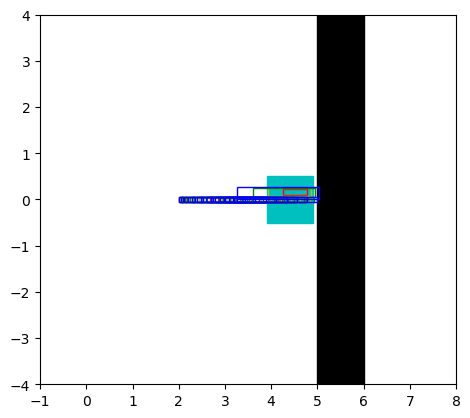

In [11]:
# Graph the resulting trajectory hyperrectangles
import matplotlib.pyplot as plt

x = distribution_rollout(res.x, xinit=x0_t)
print(x.shape)

fig, ax = plt.subplots()
for o in range(obstacles.shape[0]):
    ax.add_patch(plt.Rectangle((obstacles[o, 0], obstacles[o, 1]), obstacles[o, 2] - obstacles[o, 0], obstacles[o, 3] - obstacles[o, 1], facecolor='k', edgecolor='k', label='_nolegend_'))
ax.add_patch(plt.Rectangle((goal[0], goal[1]), goal[2] - goal[0], goal[3] - goal[1], facecolor='c', edgecolor='c', label='_nolegend_')) # nolegend label is workaround to get tikz plot working
colors = ['r', 'y', 'g', 'b']
for i in range(0, x.shape[0]):
    for j in range(0, x.shape[1]):
        ax.add_patch(plt.Rectangle((x[i, j, 0], x[i, j, 1]), x[i, j, 4] - x[i, j, 0], x[i, j, 5] - x[i, j, 1], fill=None, edgecolor=colors[i], label='_nolegend_'))
ax.set_aspect('equal')
ax.set_xlim(-1, 8)
ax.set_ylim(-4, 4)
plt.show()


In [12]:
# helper functions
def calculate_friction(fr):
    # turns fr into a uniform dist in [-1, 1)
    factor = (fr - 0.5) * 2
    if factor > 0:
        shift = 0.4 * factor
    else:
        shift = 0.1 * factor

    return 0.2 + shift

In [13]:
# BEGIN MPC
import numpy as np

seed = 269 # keep this the same for each case to ensure fairness
np.random.seed(seed)
num_trials = 10
fr = np.random.rand(num_trials)

[1. 2. 0. 0.]


/tmp/ipykernel_14230/2469510656.py:78: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 1. In a future JAX release this will be an error.
  u0_sim = jnp.vstack([u_mpc[1:, :], [0, 0]]).reshape(-1)


[1.         2.         0.         0.83923095]
[ 1.0537516   1.9355496  -0.01953043  1.686153  ]
[ 1.1757598   1.8191662  -0.05406939  2.504446  ]
[ 1.3985429   1.7047539  -0.08504069  2.5173926 ]
[ 1.6231059   1.5909817  -0.11361253  2.5220137 ]
[ 1.8500276   1.4809266  -0.13895187  2.5261893 ]
[ 2.0768461   1.3697076  -0.16280991  2.5295937 ]
[ 2.2935288   1.2391815  -0.19119701  2.5343013 ]
[ 2.5169752  1.1196051 -0.2139046  2.5495284]
[ 2.7240365   0.97085494 -0.2446336   2.536485  ]
[ 2.9565773   0.86955166 -0.25735041  2.5477967 ]
[ 3.166228    0.72477865 -0.28360653  2.5501044 ]
[ 3.3844345  0.592808  -0.3034975  2.5551128]
[ 3.604576    0.46310169 -0.3210693   2.570363  ]
[ 3.8276289   0.33537093 -0.33646694  2.5570135 ]
Goal Reached at timestep  15
[30.76447   8.188921]
[1. 2. 0. 0.]
[1.         2.         0.         0.86413527]
[ 1.06576    1.9439383 -0.0169884  1.7264225]
[ 1.1772913   1.8121576  -0.05634203  2.5886002 ]
[ 1.3728975   1.6426091  -0.10430096  3.342596  ]
[ 1.6

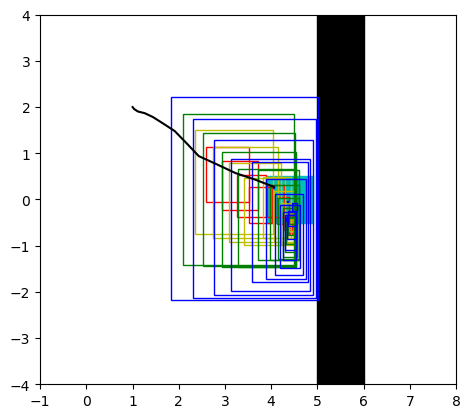

In [14]:
import tikzplotlib
# note: must have webcolors version 1.13 or this breaks
cost_trials = np.array([])
timestep_trials = []
# plot path
fig, ax = plt.subplots()

# isolate ex 8 for figure
# fr = [fr[7]]

# track time for each trial
import time
time_trials = np.array([])

for fri in fr:

    fd = calculate_friction(fri)
    cur_x = jnp.array([1.0, 2.0, 0., 0.]) # initial state
    emb_buffer = jnp.array([0.01, 0.01, 0.01, 0.01]) # 
    x0_sim = jnp.hstack([cur_x - emb_buffer, cur_x + emb_buffer]) # initial state of embedding system
    u0_sim = jnp.zeros((N, 2)).reshape(-1)

    path = cur_x
    costs = jnp.array([0, 0])
    # print("Friction: ", fd)
    start_time = time.time()
    for ti in range(0, 100):
        # run optimization
        cons = [ {'type': 'ineq', 'fun': partial(con_ineq, xinit=x0_sim), 'jac': partial(con_ineq_jac, xinit=x0_sim), 'hess': partial(con_ineq_hessvp, xinit=x0_sim)}, ]
        res = minimize_ipopt(partial(obj, xinit=x0_sim), jac=partial(obj_grad, xinit=x0_sim), hess=partial(obj_hess, xinit=x0_sim), x0=u0_sim,
                            bounds=bnds, constraints=cons, options=ipopt_opts)


        # rollout the embedding system
        x = distribution_rollout(res.x, xinit=x0_sim)
        # print(res)
        # print(res.x.reshape(-1, 2))
        # print(x)

        u_mpc = res.x.reshape(-1, 2)
        # print(u_mpc)
        # update state
        print(cur_x)
        cur_x = cur_x + dt*kinbike.f(0., cur_x, u_mpc[0, :], fd)
        costs = costs + jnp.abs(u_mpc[0, :])

        path = jnp.vstack([path, cur_x])

        ax.clear()
        for o in range(obstacles.shape[0]):
            ax.add_patch(plt.Rectangle((obstacles[o, 0], obstacles[o, 1]), obstacles[o, 2] - obstacles[o, 0], obstacles[o, 3] - obstacles[o, 1], facecolor='k', edgecolor='k', label='_nolegend_'))
        ax.add_patch(plt.Rectangle((goal[0], goal[1]), goal[2] - goal[0], goal[3] - goal[1], facecolor='c', edgecolor='c', label='_nolegend_'))
        for i in range(0, x.shape[0]):
            for j in range(0, x.shape[1]):
                ax.add_patch(plt.Rectangle((x[i, j, 0], x[i, j, 1]), x[i, j, 4] - x[i, j, 0], x[i, j, 5] - x[i, j, 1], fill=None, edgecolor=colors[i], label='_nolegend_'))
        ax.plot(path[:, 0], path[:, 1], 'k')
        ax.set_xlim(-1, 8)
        ax.set_ylim(-4, 4)
        ax.set_aspect('equal')
        # plt.show()  

        # check if system hit the goal region
        
        cur_rect = np.array([cur_x[0], cur_x[1], cur_x[0], cur_x[1]])
        se, _ = SE_order(goal, cur_rect) # check if inter rect is in goal
        if se:
            print("Goal Reached at timestep ", ti)
            break

        # check if system hit the obstacle
        if np.any([cur_rect > 5]):
            print("Obstacle Hit at timestep ", ti)
            costs = jnp.array([0, 0])
            break

        # if not, update states for next iteration
        x0_sim = jnp.hstack([cur_x - emb_buffer, cur_x + emb_buffer])
        u0_sim = jnp.vstack([u_mpc[1:, :], [0, 0]]).reshape(-1)

    print(costs)
    cost_trials = np.vstack([cost_trials, costs]) if cost_trials.size else costs
    timestep_trials.append(ti)

    time_trials = np.append(time_trials, time.time() - start_time)
    # tikzplotlib.save("fig/mpc_ex_reckless.tex") # save tikz plot for figure

In [15]:
print(cost_trials)
print(timestep_trials)
print(time_trials)
print(fd)

print("Average Cost: ", np.mean(cost_trials, axis=0))
print("Average Timesteps: ", np.mean(timestep_trials))
print("Average Time per step: ", np.mean(time_trials/timestep_trials))

[[30.76447    8.188921 ]
 [39.494972   6.5130315]
 [76.3124     5.3370485]
 [75.86094    8.808811 ]
 [72.125786   6.238555 ]
 [48.19313    6.4710226]
 [49.66887    8.31748  ]
 [84.10827    6.977573 ]
 [68.46185    7.247194 ]
 [85.23164    6.725156 ]]
[15, 12, 10, 13, 11, 11, 15, 12, 12, 12]
[ 492.18203664  634.52760553 1017.40449905 1157.34758925 1137.03226113
  685.06677747  612.28858614  941.03205204 1122.54765487 1173.80253792]
0.4801349342197921
Average Cost:  [63.022236  7.08248 ]
Average Timesteps:  12.3
Average Time per step:  75.2703083734329


Results

Full Distribution
- Timesteps: [15, 12, 10, 13, 11, 11, 15, 12, 12, 12]
- Costs: [[30.76447    8.188921 ]
 [39.494972   6.5130315]
 [76.3124     5.3370485]
 [75.86094    8.808811 ]
 [72.125786   6.238555 ]
 [48.19313    6.4710226]
 [49.66887    8.31748  ]
 [84.10827    6.977573 ]
 [68.46185    7.247194 ]
 [85.23164    6.725156 ]]

Conservative
- Timesteps: [17, 17, 15, 15, 14, 13, 21, 19, 14, 17]
- Costs: [[27.800793   8.203081 ]
 [26.462936   9.500838 ]
 [32.298344   7.775372 ]
 [55.696186   8.3913145]
 [30.931332   6.895729 ]
 [46.151318   7.6850963]
 [49.639393   9.193939 ]
 [40.128887   9.156706 ]
 [45.26479    6.895437 ]
 [47.17145    9.182794 ]]

Reckless
- Timesteps: [13, 10, 12, 16, 13, 13, 16, 16, 14, 16]
- Costs: [[38.657448   7.145873 ]
 [66.89139    5.2432346]
 [77.117874   8.2069645]
 [71.92088   10.344088 ]
 [46.799717   7.7475953]
 [37.29314    6.905661 ]
 [71.88741   11.811275 ]
 [53.142498   9.422758 ]
 [47.31014    7.851571 ]
 [62.73708   12.564521 ]]

In [16]:
full_timesteps = jnp.array([15, 12, 10, 13, 11, 11, 15, 12, 12, 12])
cons_timesteps = jnp.array([17, 17, 15, 15, 14, 13, 21, 19, 14, 17])
reck_timesteps = jnp.array([13, 10, 12, 16, 13, 13, 16, 16, 14, 16])

full_costs = jnp.array([[30.76447,    8.188921 ],
 [39.494972,   6.5130315],
 [76.3124  ,   5.3370485],
 [75.86094 ,   8.808811 ],
 [72.125786,   6.238555 ],
 [48.19313 ,   6.4710226],
 [49.66887 ,   8.31748  ],
 [84.10827 ,   6.977573 ],
 [68.46185 ,   7.247194 ],
 [85.23164 ,   6.725156 ]])
cons_costs = jnp.array([[27.800793,   8.203081 ],
 [26.462936,   9.500838 ],
 [32.298344,   7.775372 ],
 [55.696186,   8.3913145],
 [30.931332,   6.895729 ],
 [46.151318,   7.6850963],
 [49.639393,   9.193939 ],
 [40.128887,   9.156706 ],
 [45.26479 ,   6.895437 ],
 [47.17145 ,   9.182794 ]])
reck_costs = jnp.array([[38.657448,   7.145873 ],
 [66.89139 ,   5.2432346],
 [77.117874,   8.2069645],
 [71.92088 ,  10.344088 ],
 [46.799717,   7.7475953],
 [37.29314 ,   6.905661 ],
 [71.88741 ,  11.811275 ],
 [53.142498,   9.422758 ],
 [47.31014 ,   7.851571 ],
 [62.73708 ,  12.564521 ]])


print(jnp.mean(full_timesteps))
print(jnp.mean(cons_timesteps))
print(jnp.mean(reck_timesteps))

print(jnp.std(full_timesteps))
print(jnp.std(cons_timesteps))
print(jnp.std(reck_timesteps))

print(jnp.mean(full_costs, axis=0))
print(jnp.mean(cons_costs, axis=0))
print(jnp.mean(reck_costs, axis=0))

print(jnp.std(full_costs, axis=0))
print(jnp.std(cons_costs, axis=0))
print(jnp.std(reck_costs, axis=0))

12.3
16.2
13.900001
1.5524175
2.3579652
1.9723083
[63.022236  7.08248 ]
[40.154545  8.288032]
[57.375763  8.724355]
[18.395962   1.0174658]
[9.641999  0.9148128]
[13.841848  2.174585]
